In [88]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
# Load the data into a DataFrame
#data_orig = pd.read_csv(filepath_or_buffer='final_data_only_tpm.csv')

#data_pca = pd.read_csv(filepath_or_buffer='pca_data.csv')
#data_pca.drop(data_pca.columns[0], axis=1, inplace=True)
"""
# Split the data into features (X) and target variable (y)
#X = data.drop('cancer_type', axis=1)
#y = data['cancer_type']

# Split the data into training and validation sets
#train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=42)


#train_dataloader = DataLoader(
#    dataset=train_dataset, batch_size=batch_size, shuffle=True
#)
#val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)
"""
#data.head()

"\n# Split the data into features (X) and target variable (y)\n#X = data.drop('cancer_type', axis=1)\n#y = data['cancer_type']\n\n# Split the data into training and validation sets\n#train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=42)\n\n\n#train_dataloader = DataLoader(\n#    dataset=train_dataset, batch_size=batch_size, shuffle=True\n#)\n#val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)\n"

In [89]:
# Split the data into training and validation sets
import torch
# Split the data into features (X) and target variable (y)

data = data_orig

map = {
    "kidney chromophobe": 0,
    "kidney renal papillary cell carcinoma": 1,
    "kidney renal clear cell carcinoma": 2,
}

data1 = data.copy()
data1['cancer_type'] = data1['cancer_type'].replace(map)

X = data1.drop('cancer_type', axis=1)
y = data1['cancer_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=42)

X_train_tens = torch.tensor(X_train.values).float()
X_test_tens = torch.tensor(X_test.values).float()
y_train_tens = torch.tensor(y_train.values)
y_test_tens = torch.tensor(y_test.values)

data1.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6,cancer_type
0,19.7011,0.1125,46.1397,1.8913,0.2670,18.6466,4.3945,24.1591,6.7242,9.4371,...,0.0,0.0641,0.0,1.0888,0.0,3.1977,0.0,0.0104,0.3953,0
1,31.6275,0.0000,45.5189,2.8743,0.4744,4.2348,1.4145,60.8153,15.4309,7.5267,...,0.0,0.0781,0.0,0.0000,0.0,15.4262,0.0,0.0042,0.4094,0
2,35.9928,0.5207,108.0270,4.8134,0.8010,4.5446,3.2850,33.1630,13.1085,12.1888,...,0.0,0.1049,0.0,0.0000,0.0,13.2312,0.0,0.1154,0.3050,0
3,18.2605,0.0921,27.5398,2.3258,0.3473,4.5023,1.5078,47.2006,10.6721,5.0657,...,0.0,0.1193,0.0,0.0000,0.0,6.4516,0.0,0.0141,0.1416,0
4,68.8052,3.4134,88.0619,6.2415,1.2251,9.5310,30.6990,66.3841,12.9370,20.1289,...,0.0,0.1141,0.0,0.0000,0.0,21.8857,0.0,0.0394,0.3547,0


In [104]:
import torch.utils.data
import torch.nn as nn
from torch.utils.data import DataLoader

# Build model
class MultiClassificationModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()

        """ n_input_channels = 3  # i.e., length of our OHE scheme
        n_filters = 32  # i.e., no. of kernels
        kernel_size = 3
        conv_out_len = output_features - kernel_size + 1
        self.net = nn.Sequential(
            nn.Conv1d(
                in_channels=n_input_channels,
                out_channels=n_filters,
                kernel_size=kernel_size,
            ),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=n_filters * conv_out_len, out_features=1),
        ) # sizes don't add up.. "Given groups=1, weight of size [32, 3, 3], expected input[1, 822, 60660] to have 3 channels, but got 822 channels instead" """

        self.bens_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            nn.Softmax(dim=1),
            nn.Dropout(0.5)
        )

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            #nn.Sigmoid(),
            #nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
            #nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)



In [105]:
NUM_FEATURES = X.shape[1] #1028 #60660
print(NUM_FEATURES)
NUM_CLASSES = 3
device = "cpu"

# Create an instance of BlobModel and send it to the target device
model = MultiClassificationModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES).to(device)
model

60660


MultiClassificationModel(
  (bens_layer_stack): Sequential(
    (0): Linear(in_features=60660, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=3, bias=True)
    (3): Softmax(dim=1)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=60660, out_features=8, bias=True)
    (1): ReLU()
    (2): ReLU()
    (3): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [106]:
LR = 0.0005

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=LR) # exercise: try changing the learning rate here and seeing what happens to the model

In [107]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model(X_train_tens.to(device))[:5]

tensor([[-202.7336,   -2.9887,   -0.8178],
        [-279.4873,  -16.6191,   19.7937],
        [-102.8949,   48.5136,  -46.6255],
        [-221.0672,   22.8827,   25.5104],
        [-346.9634,  -47.0106,   -9.7404]], grad_fn=<SliceBackward0>)

In [108]:
model(X_train_tens.to(device))[0].shape, NUM_CLASSES 

(torch.Size([3]), 3)

In [109]:
# Make prediction logits with model
y_logits = model(X_test_tens.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-135.9156,   33.8904,   -1.1670],
        [-259.8529,  -21.4767,   -4.6599],
        [-202.6197,   81.2833, -132.3384],
        [-160.1348,   87.0007,  -49.0385],
        [-137.1934,   23.7253,  -43.0880]], grad_fn=<SliceBackward0>)
tensor([[0.0000e+00, 1.0000e+00, 5.9534e-16],
        [0.0000e+00, 4.9725e-08, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 9.6236e-30]], grad_fn=<SliceBackward0>)


In [110]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [111]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0000e+00, 1.0000e+00, 5.9534e-16], grad_fn=<SelectBackward0>)
tensor(1)


In [115]:
# Calculate accuracy (a classification metric)
def accuracy_fn_alt(y_true, y_logits):
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def accuracy_fn_neu(y_true, y_logits):
    _, predicted = torch.max(y_logits, 1)# go from logits -> prediction probabilities -> prediction labels
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy * 100

accuracy_fn = accuracy_fn_neu

In [118]:
# Fit the model
#torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Initialize lists to store training and test metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Put data to target device
X_train_tens, y_train_tens = X_train_tens.to(device), y_train_tens.to(device)
X_test_tens, y_test_tens = X_test_tens.to(device), y_test_tens.to(device)

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_train_tens) # model outputs raw logits 
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train_tens) 

    # Acc
    train_acc = accuracy_fn(y_true=y_train_tens, y_logits=y_logits)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test_tens)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test_tens)
      test_acc = accuracy_fn(y_true=y_test_tens, y_logits=test_logits)

      # Log metrics
      train_losses.append(loss.item())
      test_losses.append(test_loss.item())
      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.16850, Acc: 31.27% | Test Loss: 2.36463, Test Acc: 36.41%
Epoch: 10 | Loss: 1.16758, Acc: 31.27% | Test Loss: 2.36392, Test Acc: 36.41%
Epoch: 20 | Loss: 1.16667, Acc: 31.27% | Test Loss: 2.36321, Test Acc: 36.41%
Epoch: 30 | Loss: 1.16576, Acc: 31.27% | Test Loss: 2.36250, Test Acc: 36.41%
Epoch: 40 | Loss: 1.16485, Acc: 31.27% | Test Loss: 2.36179, Test Acc: 36.41%
Epoch: 50 | Loss: 1.16394, Acc: 31.27% | Test Loss: 2.36108, Test Acc: 36.41%
Epoch: 60 | Loss: 1.16304, Acc: 31.27% | Test Loss: 2.36038, Test Acc: 36.41%
Epoch: 70 | Loss: 1.16214, Acc: 31.27% | Test Loss: 2.35968, Test Acc: 36.41%
Epoch: 80 | Loss: 1.16124, Acc: 31.27% | Test Loss: 2.35897, Test Acc: 36.41%
Epoch: 90 | Loss: 1.16034, Acc: 31.27% | Test Loss: 2.35827, Test Acc: 36.41%


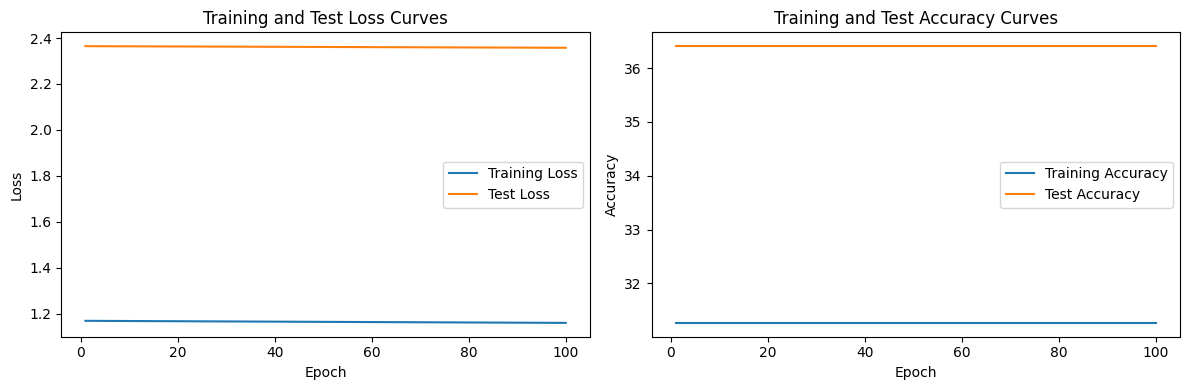

Training complete!


In [120]:

from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss Curves')

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy Curves')

plt.tight_layout()
plt.show()

print("Training complete!")